# EDA

In [54]:
import numpy as np
import pandas as pd
import os

import cv2
from tqdm import tqdm          
from random import shuffle
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print(tf.python.client.device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7406304516710109763
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5311675387100208078
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6507127385
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5705839855076522710
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9918728867864698484
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_path = get_path('./train')
test_path = get_path('./test')

#### Image processing

In [3]:
#one-hot encoding for dogs and cats
def label_img(img):
    category = img.split('.')[-3]
    if category == 'cat': return [1,0]
    elif category == 'dog': return [0,1]

In [4]:
def process_data(img_data, data_dir, isTrain=True):
    data_df = []
    for img in tqdm(img_data):
        path = os.path.join(data_dir,img)         #Assigning path to images by concatenating directory and images
        if(isTrain):
            label = label_img(img)            #Assign labels to image in training 
        else:
            label = img.split('.')[0]     #assign labels to test
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224)) #resize image to (224, 224)
        data_df.append([np.array(img),np.array(label)])          #append image and labels as numpy array in data_df list
    shuffle(data_df)
    return data_df

In [5]:
train = process_data(train_path, './train/')
test = process_data(test_path, './test/', False)

100%|██████████| 12500/12500 [00:30<00:00, 411.86it/s]


#### Image display

In [15]:
def show_images(data, isTest=False):
    f, ax = plt.subplots(nrows = 4, ncols = 4, figsize = (12, 12))
    for i,data in enumerate(data[:16]):              #enumerate helps in keeping track of count of iterations
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)                    #to get maximum indices of an array
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//4, i%4].imshow(img_data)
        ax[i//4, i%4].axis('off')                 #removing axis for better look
        ax[i//4, i%4].set_title("Label: {}".format(str_label))
    plt.show()

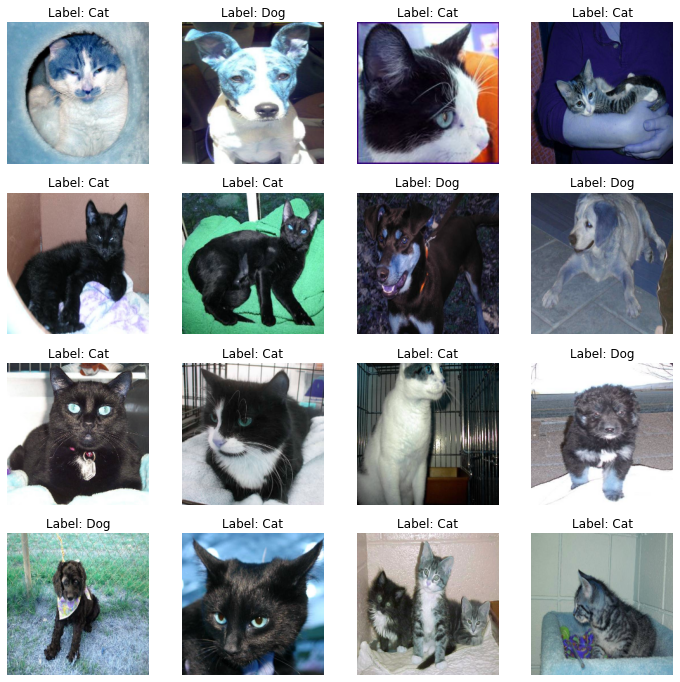

In [16]:
show_images(train)

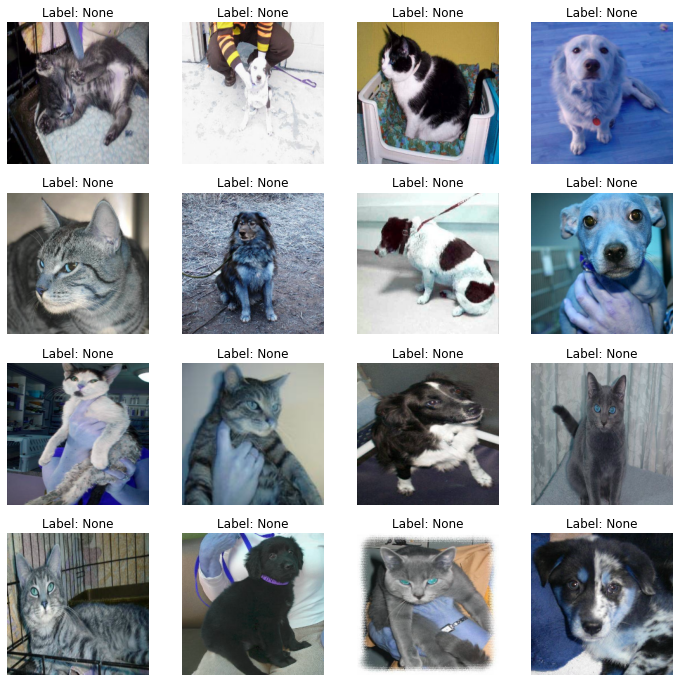

In [17]:
show_images(test,True)

### ImageDataGenerator

In [21]:
#labeling
def get_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label

train_label = get_label('./train')

#Convert the images and labels into dataframe.
train_df = pd.DataFrame({'filename': train_path, 'label': train_label})
train_df.sample(5)

test_df = pd.DataFrame({'filename': test_path}) 

filename label
4289   cat.2608.jpg     0
17036  dog.2830.jpg     1
12120  cat.9657.jpg     0
20578  dog.6018.jpg     1
3427   cat.1832.jpg     0

In [163]:
#train-test-split
train_df, valid_df = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 42)
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


In [23]:
train_datagen = ImageDataGenerator(rotation_range = 10, #random rotations within 10 degrees
                                   zoom_range = 0.1, #random zoom within 10%
                                   horizontal_flip = True, #random horizontal flipping
                                   fill_mode = 'nearest', #points outside input boundaries are filled by nearest
                                   width_shift_range = 0.1, #width shifting
                                   height_shift_range = 0.1, #height shifting
                                   preprocessing_function = preprocess_input #preprocessing function from ResNet50
                                  )

train_gen = train_datagen.flow_from_dataframe(train_df, 
                                              directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (224,224),
                                              batch_size = 16, 
                                              class_mode='binary')

#validation and test sets obviously doesn't need so much randomness
image_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)


valid_gen = image_datagen.flow_from_dataframe(valid_df, 
                                              directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (224,224),
                                              batch_size = 16, 
                                              class_mode='binary')

test_gen = image_datagen.flow_from_dataframe(test_df, 
                                            directory = './test', 
                                            batch_size = 64, 
                                            x_col = 'filename', 
                                            y_col = None, 
                                            class_mode = None, 
                                            shuffle = False,
                                            target_size = (224,224))

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### Output functions

In [27]:
def loss_acc_plot(modelhistory):
    scores = pd.DataFrame(modelhistory.history)
    scores[['loss', 'val_loss']].plot();
    scores[['acc', 'val_acc']].plot();

In [46]:
def submit(model, filename=''):
    y_pred = model.predict(test_gen)
    prediction = y_pred.clip(min = 0.005, max = 0.995)
    
    if filename != '':
        submission_df = pd.read_csv('sample_submission.csv')
        for i, fname in enumerate(test_path):
            index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
            submission_df.at[index-1, 'label'] = prediction[i]
        submission_df.to_csv(filename+'.csv', index=False)

In [25]:
def test_sample(model):
    test_sample = test_df.sample(n = 16)
    test_array = test_sample['filename'].to_numpy()
    
    label_pred = []
    for path in test_array:
        full_path = './test/'+path
        x = load_img(full_path, target_size=(224, 224))
        img_array = img_to_array(x)
        img_array = np.expand_dims(img_array, axis=0)
        
        out =  model.predict(img_array)    
        out = 'Dog' if float(out) >0.5 else 'Cat'
        label_pred.append(out)
    
    plt.figure(figsize=(12, 12))
    for i in range(0, 16):
        plt.subplot(4, 4, i+1)
        img = test_array[i]
        path = './test/' + img
        image = load_img(path, target_size=(224, 224))  
        plt.title('Predicted: {}'.format(label_pred[i]), fontsize= 10)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout();

# Modeling

#### Model 1

In [36]:
model = Sequential([
    #Conv layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    #Conv layer 2
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    #Flatten
    Flatten(),
    #full connection
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    #drop out
    Dropout(0.5),
    #sigmoid
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

model.summary()

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

checkpointer = ModelCheckpoint(filepath = '2 layer CNN 32 neurons.hdf5', save_best_only = True, save_weights_only = True)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 109, 109, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 93312)            

In [37]:
history = model.fit(
    train_gen,
    epochs = 20,
    verbose = 1,
    validation_data = valid_gen,
    callbacks = [checkpointer]
)

Epoch 1/20
1250/1250 [==============================] - 215s 172ms/step - loss: 1.6953 - acc: 0.6077 - val_loss: 1.2138 - val_acc: 0.6228
Epoch 2/20
1250/1250 [==============================] - 212s 170ms/step - loss: 1.3351 - acc: 0.6568 - val_loss: 1.4001 - val_acc: 0.6814
Epoch 3/20
1250/1250 [==============================] - 212s 170ms/step - loss: 1.4118 - acc: 0.6916 - val_loss: 1.3960 - val_acc: 0.7474
Epoch 4/20
1250/1250 [==============================] - 211s 169ms/step - loss: 1.4234 - acc: 0.7251 - val_loss: 1.3712 - val_acc: 0.7214
Epoch 5/20
1250/1250 [==============================] - 212s 169ms/step - loss: 1.3620 - acc: 0.7391 - val_loss: 1.2717 - val_acc: 0.7730
Epoch 6/20
1250/1250 [==============================] - 213s 171ms/step - loss: 1.2765 - acc: 0.7500 - val_loss: 1.1684 - val_acc: 0.7778
Epoch 7/20
1250/1250 [==============================] - 220s 176ms/step - loss: 1.2005 - acc: 0.7527 - val_loss: 1.1842 - val_acc: 0.7184
Epoch 8/20
1250/1250 [============

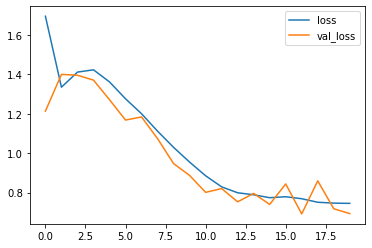

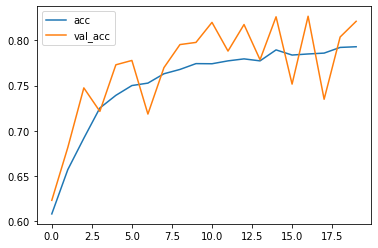

In [39]:
loss_acc_plot(model.history)

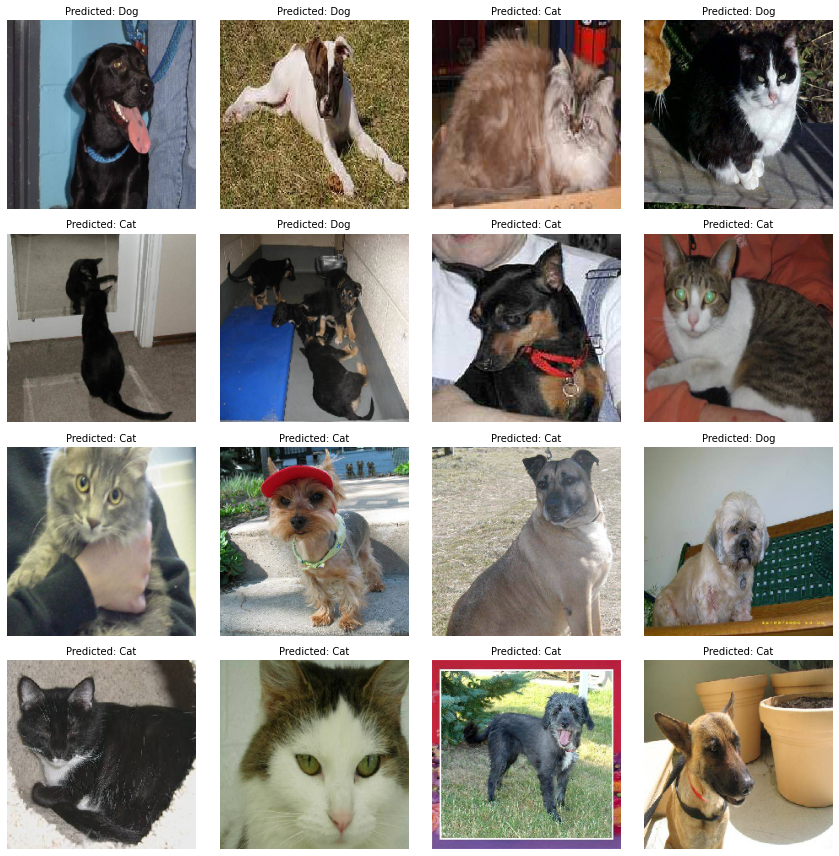

In [40]:
test_sample(model)

#### Model 2

In [42]:
model = Sequential([
    #Conv layer 1, 2
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    #Conv layer 3, 4
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    #Flatten
    Flatten(),
    #full connection
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    #drop out
    Dropout(0.5),
    #sigmoid
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

model.summary()

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

checkpointer = ModelCheckpoint(filepath = '8 layer CNN 32 neurons.hdf5', save_best_only = True, save_weights_only = True)

history = model.fit(
    train_gen,
    epochs = 20,
    verbose = 2,
    validation_data = valid_gen,
    callbacks = [checkpointer]
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 112, 112, 32)     

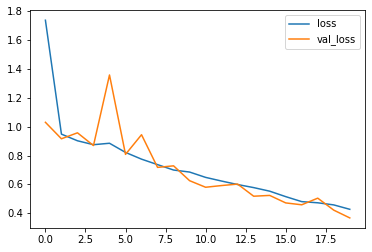

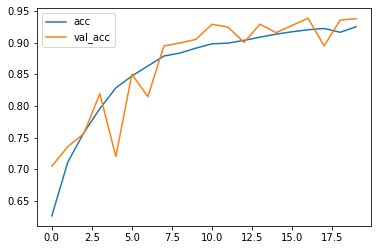

In [43]:
loss_acc_plot(model.history)

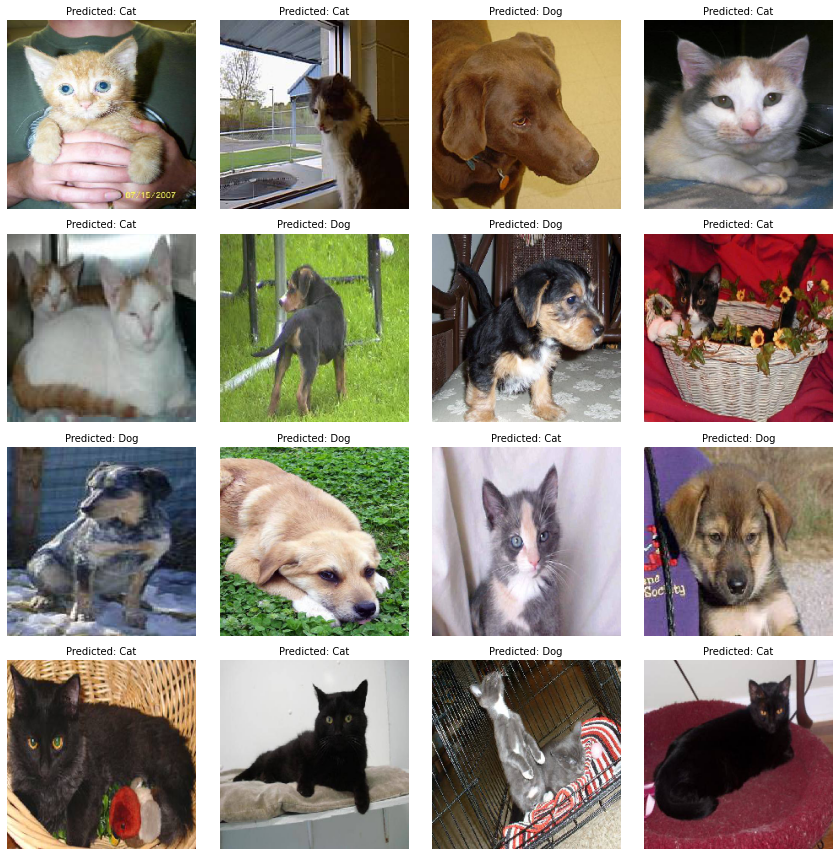

In [44]:
test_sample(model)

In [47]:
submit(model, 'model 2')

#### Model 3

In [67]:
model = Sequential([
    #Conv layer 1, 2
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    #Conv layer 3, 4
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPool2D(2, 2),
    
    #Flatten
    Flatten(),
    #full connection
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    #drop out
    Dropout(0.5),
    #sigmoid
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

model.summary()

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

earlystopping = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, 
                                                 verbose=1, mode="auto", baseline=None, restore_best_weights=True)

checkpointer = ModelCheckpoint(filepath = '8 layer CNN stacked neurons.hdf5', save_best_only = True, save_weights_only = True)

history = model.fit(
    train_gen,
    epochs = 50,
    verbose = 2,
    validation_data = valid_gen,
    callbacks = [earlystopping, checkpointer]
)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_37 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_38 (Batc (None, 112, 112, 32)    

In [69]:
earlystopping = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, 
                                                 verbose=1, mode="auto", baseline=None, restore_best_weights=True)

history = model.fit(
    train_gen,
    epochs = 50,
    verbose = 2,
    validation_data = valid_gen,
    callbacks = [earlystopping, checkpointer]
)

Epoch 1/50
1250/1250 - 202s - loss: 0.2754 - acc: 0.9413 - val_loss: 0.3006 - val_acc: 0.9314
Epoch 2/50
1250/1250 - 203s - loss: 0.2707 - acc: 0.9419 - val_loss: 0.2578 - val_acc: 0.9458
Epoch 3/50
1250/1250 - 203s - loss: 0.2618 - acc: 0.9452 - val_loss: 0.2988 - val_acc: 0.9322
Epoch 4/50
1250/1250 - 201s - loss: 0.2532 - acc: 0.9485 - val_loss: 0.2635 - val_acc: 0.9510
Epoch 5/50
Restoring model weights from the end of the best epoch.
1250/1250 - 200s - loss: 0.2510 - acc: 0.9514 - val_loss: 0.2627 - val_acc: 0.9454
Epoch 00005: early stopping


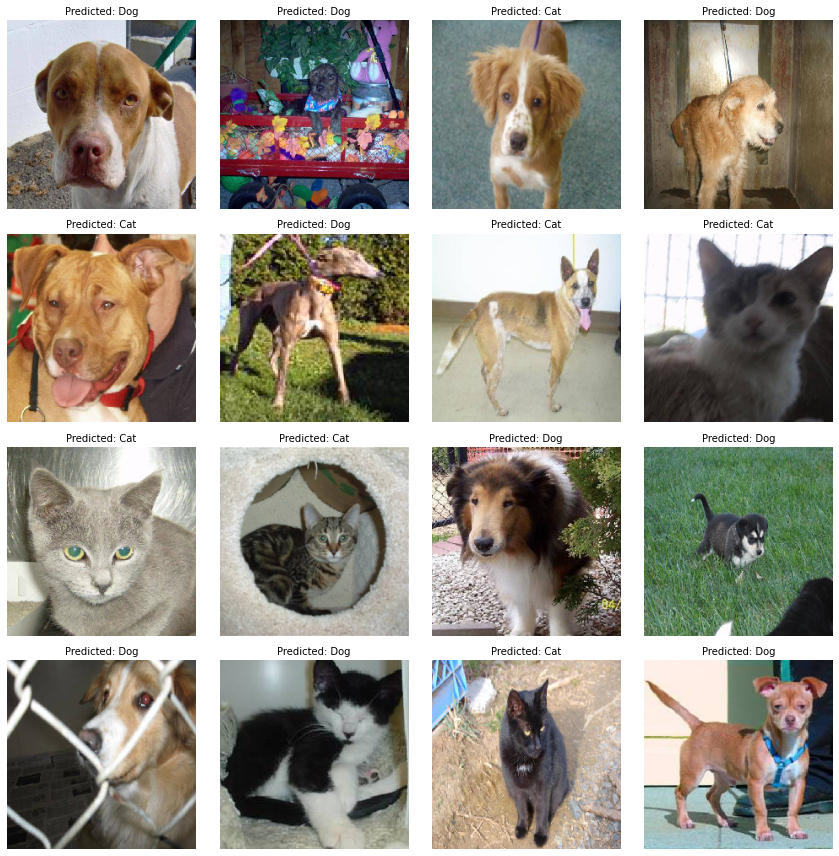

In [71]:
test_sample(model)

In [72]:
#submit(model, 'model 3')
submit(model, 'model 3a')

#### Model 5 - ResNet50

In [74]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False 

model.summary()

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [75]:
model.load_weights('resnet50 model 10 epochs.hdf5')

In [76]:
history = model.fit(
    train_gen,
    epochs = 10,
    verbose = 1,
    validation_data = valid_gen,
    callbacks = [checkpointer]
)

Epoch 1/10
1250/1250 [==============================] - 204s 163ms/step - loss: 0.0599 - acc: 0.9865 - val_loss: 0.0454 - val_acc: 0.9900
Epoch 2/10
1250/1250 [==============================] - 223s 179ms/step - loss: 0.0569 - acc: 0.9869 - val_loss: 0.0421 - val_acc: 0.9898
Epoch 3/10
1250/1250 [==============================] - 205s 164ms/step - loss: 0.0476 - acc: 0.9883 - val_loss: 0.0673 - val_acc: 0.9850
Epoch 4/10
1250/1250 [==============================] - 234s 187ms/step - loss: 0.0510 - acc: 0.9879 - val_loss: 0.0508 - val_acc: 0.9880
Epoch 5/10
1250/1250 [==============================] - 251s 200ms/step - loss: 0.0449 - acc: 0.9880 - val_loss: 0.0408 - val_acc: 0.9896
Epoch 6/10
1250/1250 [==============================] - 201s 161ms/step - loss: 0.0422 - acc: 0.9891 - val_loss: 0.0435 - val_acc: 0.9894
Epoch 7/10
1250/1250 [==============================] - 201s 161ms/step - loss: 0.0377 - acc: 0.9888 - val_loss: 0.0415 - val_acc: 0.9882
Epoch 8/10
1250/1250 [============

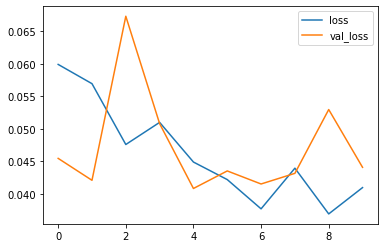

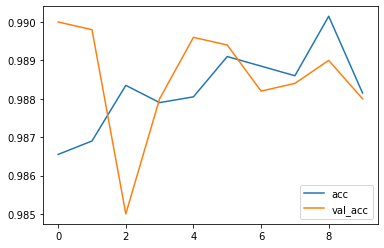

In [77]:
loss_acc_plot(model.history)

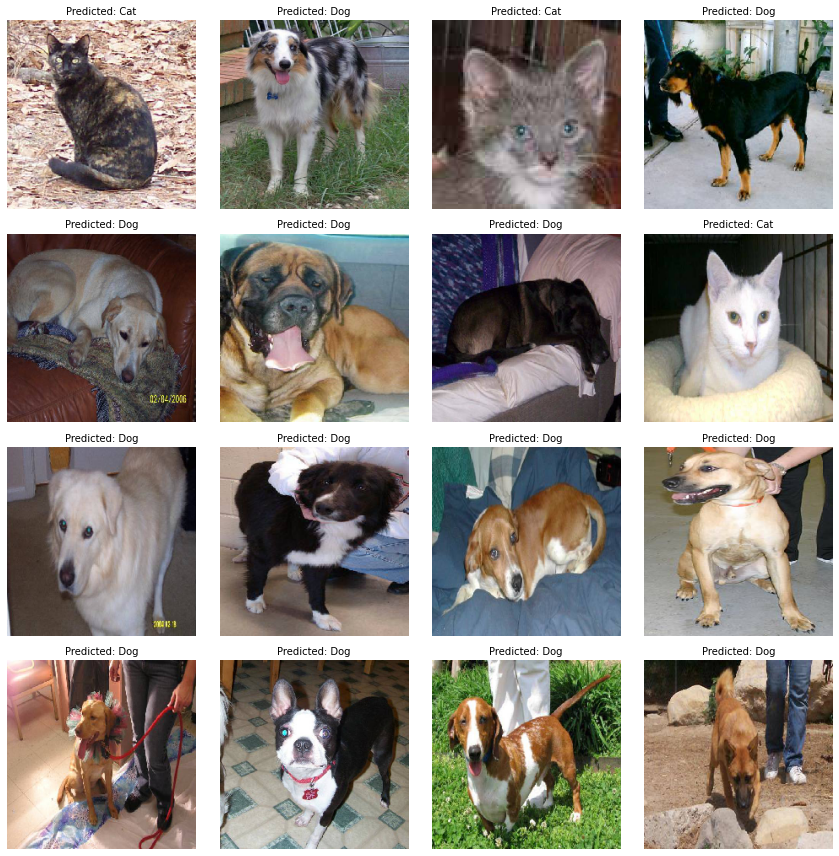

In [78]:
test_sample(model)

In [79]:
submit(model, 'model 5a')

#### Model 4a

In [152]:
model = Sequential([
        Conv2D(32, 3, activation='relu', padding='same', input_shape=(224, 224, 3)),
        Conv2D(32, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),
    
        Conv2D(32, 3, padding='same', activation='relu'),
        Conv2D(32, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),
    
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),
    
        Conv2D(64, 3, padding='same', activation='relu'),
        Conv2D(64, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),
    
        Conv2D(128, 3, padding='same', activation='relu'),
        Conv2D(128, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),

        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),
    
        Conv2D(256, 3, padding='same', activation='relu'),
        Conv2D(256, 3, padding='same', activation='relu'),
        BatchNormalization(),
        MaxPool2D(2, 2),

        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1, activation = "sigmoid")

    ])

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-3), metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 224, 224, 32)      9248      
_________________________________________________________________
batch_normalization_48 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_49 (Batc (None, 112, 112, 32)    

In [155]:
model.load_weights('14 layers.hdf5')

In [157]:
history = model.fit(
    train_gen,
    epochs = 5,
    verbose = 1,
    validation_data = valid_gen
)

Epoch 1/5
1250/1250 [==============================] - 203s 162ms/step - loss: 0.2110 - accuracy: 0.9186 - val_loss: 0.3934 - val_accuracy: 0.8488
Epoch 2/5
1250/1250 [==============================] - 202s 161ms/step - loss: 0.1763 - accuracy: 0.9307 - val_loss: 0.2060 - val_accuracy: 0.9118
Epoch 3/5
1250/1250 [==============================] - 202s 162ms/step - loss: 0.1606 - accuracy: 0.9373 - val_loss: 0.1368 - val_accuracy: 0.9410
Epoch 4/5
1250/1250 [==============================] - 202s 161ms/step - loss: 0.1466 - accuracy: 0.9393 - val_loss: 0.1472 - val_accuracy: 0.9360
Epoch 5/5
1250/1250 [==============================] - 202s 162ms/step - loss: 0.1404 - accuracy: 0.9414 - val_loss: 0.1275 - val_accuracy: 0.9530


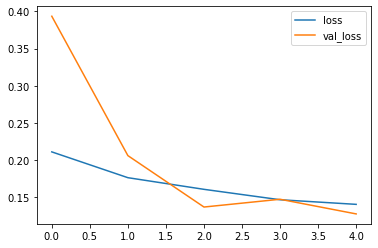

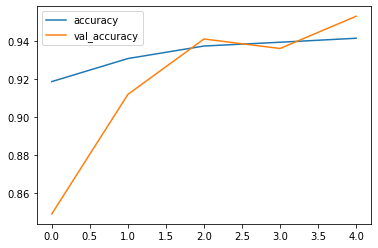

In [159]:
 scores = pd.DataFrame(model.history.history)
scores[['loss', 'val_loss']].plot();
scores[['accuracy', 'val_accuracy']].plot();

In [160]:
submit(model, 'model 4 final')

### Precision-recall and ROC-AUC of model 3

In [180]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [164]:
val_gen = image_datagen.flow_from_dataframe(valid_df, 
                                              directory = './train', 
                                              x_col = 'filename', 
                                              y_col = 'label', 
                                              target_size = (224,224),
                                              batch_size = 16, 
                                              class_mode='binary',
                                             shuffle=False)

Found 5000 validated image filenames belonging to 2 classes.


In [165]:
 y_pred = model.predict(val_gen)

In [166]:
plot_df = pd.DataFrame(columns=['id', 'true', 'pred'])
plot_df['true'] = valid_df['label']
plot_df['pred'] = y_pred.ravel()

In [175]:
fpr, tpr, thresholds = roc_curve(plot_df['true'].astype(int), plot_df['pred'], pos_label=1)
area = auc(fpr, tpr)

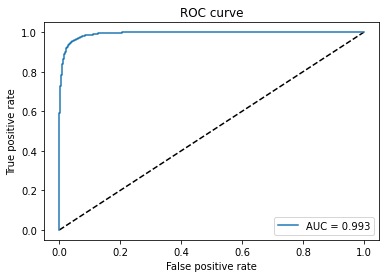

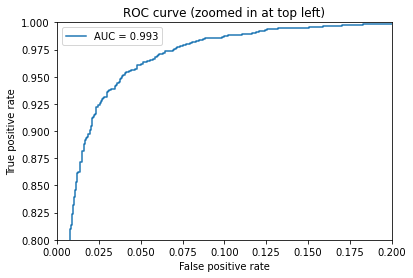

In [176]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show();
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(area))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show();

In [200]:
precision, recall, thresholds = precision_recall_curve(plot_df['true'].astype(int), plot_df['pred'], pos_label=1)
#area = auc(precision, recall)

In [198]:
precision.mean()

0.964279956819493

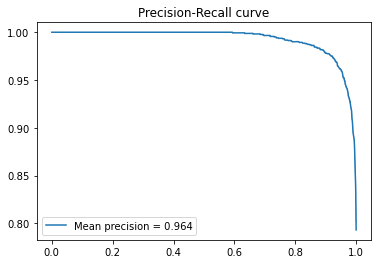

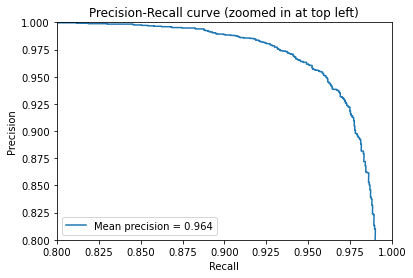

In [209]:
plt.figure(1)
sns.lineplot(x=recall, y=precision, label='Mean precision = 0.964')
plt.title('Precision-Recall curve')
plt.show();
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0.8, 1)
plt.ylim(0.8, 1)
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(precision, recall, label='Mean precision = 0.964')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show();